In [ ]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torchvision

Preparing DataSet

In [ ]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [ ]:
#taking a look:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

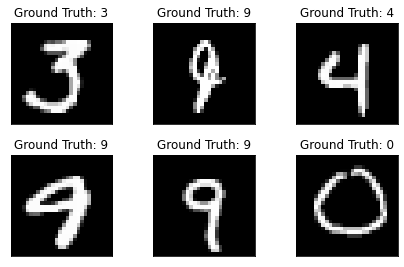

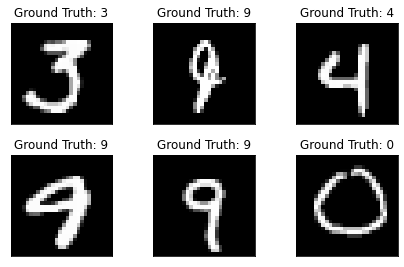

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

##Modeling

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)#Images are gray-->1
        self.batch=nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)#320=7*7*20
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.batch(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Training

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
net = Net()
optimizer = optim.SGD(net.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  net.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()#Because pytorch accumulate gradients by default
    output = net(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(net.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

Testing

In [ ]:
def test():
  net.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = net(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3222, Accuracy: 960/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.340711
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.289400
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.247214
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.181457
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.140295
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.095675
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.069427
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.972243
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.935322
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.658361
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.549817
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.416727
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.523963
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.284096
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.285311
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.046615
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.007658
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.128564
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.190035
Train Epoch: 1 [12160/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


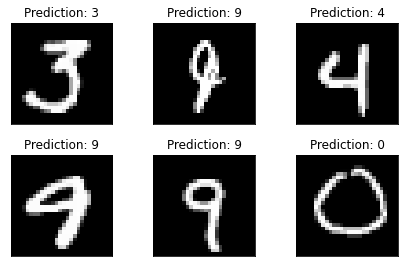

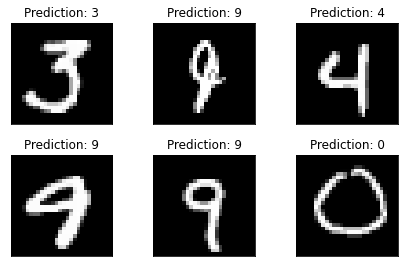

In [ ]:
with torch.no_grad():
  output = net(example_data)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig